# Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [2]:
dataset = pd.read_csv('data/celebdf_features.csv',sep=',')

In [3]:
dataset.head(5)

,filename,is_deepfake,face_detection_ratio,face_detector_0_ratio,face_detector_1_ratio,eye-blink-ratio,F-H-avg-value,F-H-variance-value,F-H-avg-change,F-H-max-change,...,O-hu-5-avg-change,O-hu-5-max-change,O-hu-5-avg-interp-diff,O-hu-5-max-interp-diff,O-hu-6-avg-value,O-hu-6-variance-value,O-hu-6-avg-change,O-hu-6-max-change,O-hu-6-avg-interp-diff,O-hu-6-max-interp-diff
0,id24_id25_0005,1,1.0,1.0,0.0,0.0297,10.2947,0.1848,0.1568,0.6384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,id43_id47_0000,1,1.0,1.0,0.0,0.0188,10.7345,0.0448,0.1132,0.4013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,id10_id7_0008,1,1.0,1.0,0.0,0.0026,9.5433,0.8177,0.2985,2.4350,...,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
3,id31_id38_0001,1,1.0,1.0,0.0,0.0054,35.1457,44.7263,4.4102,17.4778,...,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
4,id43_id46_0001,1,1.0,1.0,0.0,0.0293,10.6863,0.6932,0.2362,2.6182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print("Deepfakes: {}".format(sum(dataset['is_deepfake'] == 1)))
print("Reals: {}".format(sum(dataset['is_deepfake'] == 0)))

Deepfakes: 1000
Reals: 889


In [5]:
id_label = 'filename'
y_label = 'is_deepfake'
facial_features = [x for x in dataset.columns.values if x[0] == 'F' and x[1:6] != '-hog-']
hog_features = [x for x in dataset.columns.values if x[1:6] == '-hog-']
outsite_features = [x for x in dataset.columns.values if x[0] == 'O']
other_features = [x for x in dataset.columns.values if x[0] not in ['F', 'O'] and x not in [y_label, id_label]]

In [6]:
print("facial_features: {}".format(len(facial_features)))
print("hog_features: {}".format(len(hog_features)))
print("outsite_features: {}".format(len(outsite_features)))
print("other_features: {}".format(len(other_features)))

facial_features: 126
hog_features: 3456
outsite_features: 114
other_features: 4


# PCA

In [7]:
x_features_columns = list(dataset.columns.values)
x_features_columns.remove(id_label)
x_features_columns.remove(y_label)

x_features = dataset[x_features_columns]

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x_features_pca = StandardScaler().fit_transform(x_features)
pca = PCA(.95)
pca.fit(x_features_pca)
x_features_pca = pca.transform(x_features_pca)

In [9]:
print(x_features.shape)
print(x_features_pca.shape)

(1889, 3700)
(1889, 733)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_features_pca,
                                                    dataset[y_label],
                                                    test_size=0.2, random_state=3)

In [11]:
print(X_train.shape)
print(X_test.shape)

(1511, 733)
(378, 733)


## CV Grid Search

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### Naive Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB

param_grid = {}

grid = GridSearchCV(GaussianNB(), param_grid, refit=True, cv=3, n_jobs=-1, scoring='accuracy')

grid.fit(X_train, y_train)

print(grid.best_params_)
grid_predictions = grid.predict(X_test)
 
print(classification_report(y_test, grid_predictions))

model_naive_bayes = grid.best_estimator_

{}
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       173
           1       0.71      0.80      0.76       205

    accuracy                           0.72       378
   macro avg       0.72      0.71      0.71       378
weighted avg       0.72      0.72      0.72       378



### SVM

In [14]:
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'rbf', "sigmoid", "poly"],
              'degree': [2, 3, 4]}

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=3, n_jobs=-1, scoring='accuracy')

grid.fit(X_train, y_train)

print(grid.best_params_)
grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

model_svm = grid.best_estimator_

{'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       173
           1       0.68      0.79      0.73       205

    accuracy                           0.69       378
   macro avg       0.69      0.68      0.68       378
weighted avg       0.69      0.69      0.68       378



### k-NN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.linspace(1, X_train.shape[1], num=100, dtype = int)}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, cv=3, n_jobs=-1, scoring='accuracy')

grid.fit(X_train, y_train)

print(grid.best_params_)
grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

model_knn = grid.best_estimator_

{'n_neighbors': 30}
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       173
           1       0.66      0.73      0.69       205

    accuracy                           0.65       378
   macro avg       0.64      0.64      0.64       378
weighted avg       0.64      0.65      0.64       378



### Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': np.linspace(10, X_train.shape[1], num=100, dtype = int),
              'min_samples_split': [2,5,10,15,25]}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, cv=3, n_jobs=-1, scoring='accuracy')

grid.fit(X_train, y_train)

print(grid.best_params_)
grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

model_decision_tree = grid.best_estimator_

{'max_depth': 10, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       173
           1       0.62      0.64      0.63       205

    accuracy                           0.59       378
   macro avg       0.59      0.59      0.59       378
weighted avg       0.59      0.59      0.59       378



### RandomForest

In [18]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [10, 50, 100, 250, 400],
              'max_depth': np.linspace(1, X_train.shape[1], num=100, dtype = int)}

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, cv=3, n_jobs=-1, scoring='accuracy')

grid.fit(X_train, y_train)

print(grid.best_params_)
grid_predictions = grid.predict(X_test)

print(classification_report(y_test, grid_predictions))

model_random_forest = grid.best_estimator_

{'max_depth': 733, 'n_estimators': 400}
              precision    recall  f1-score   support

           0       0.69      0.54      0.61       173
           1       0.67      0.80      0.73       205

    accuracy                           0.68       378
   macro avg       0.68      0.67      0.67       378
weighted avg       0.68      0.68      0.67       378



## Compare models

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

Accuracy Score
--- KNN:
train = 0.685, test = 0.646

--- Naive Bayes:
train = 0.754, test = 0.72

--- Decision Tree:
train = 0.89, test = 0.593

--- Random Forest:
train = 1.0, test = 0.68

--- SVM:
train = 0.756, test = 0.685



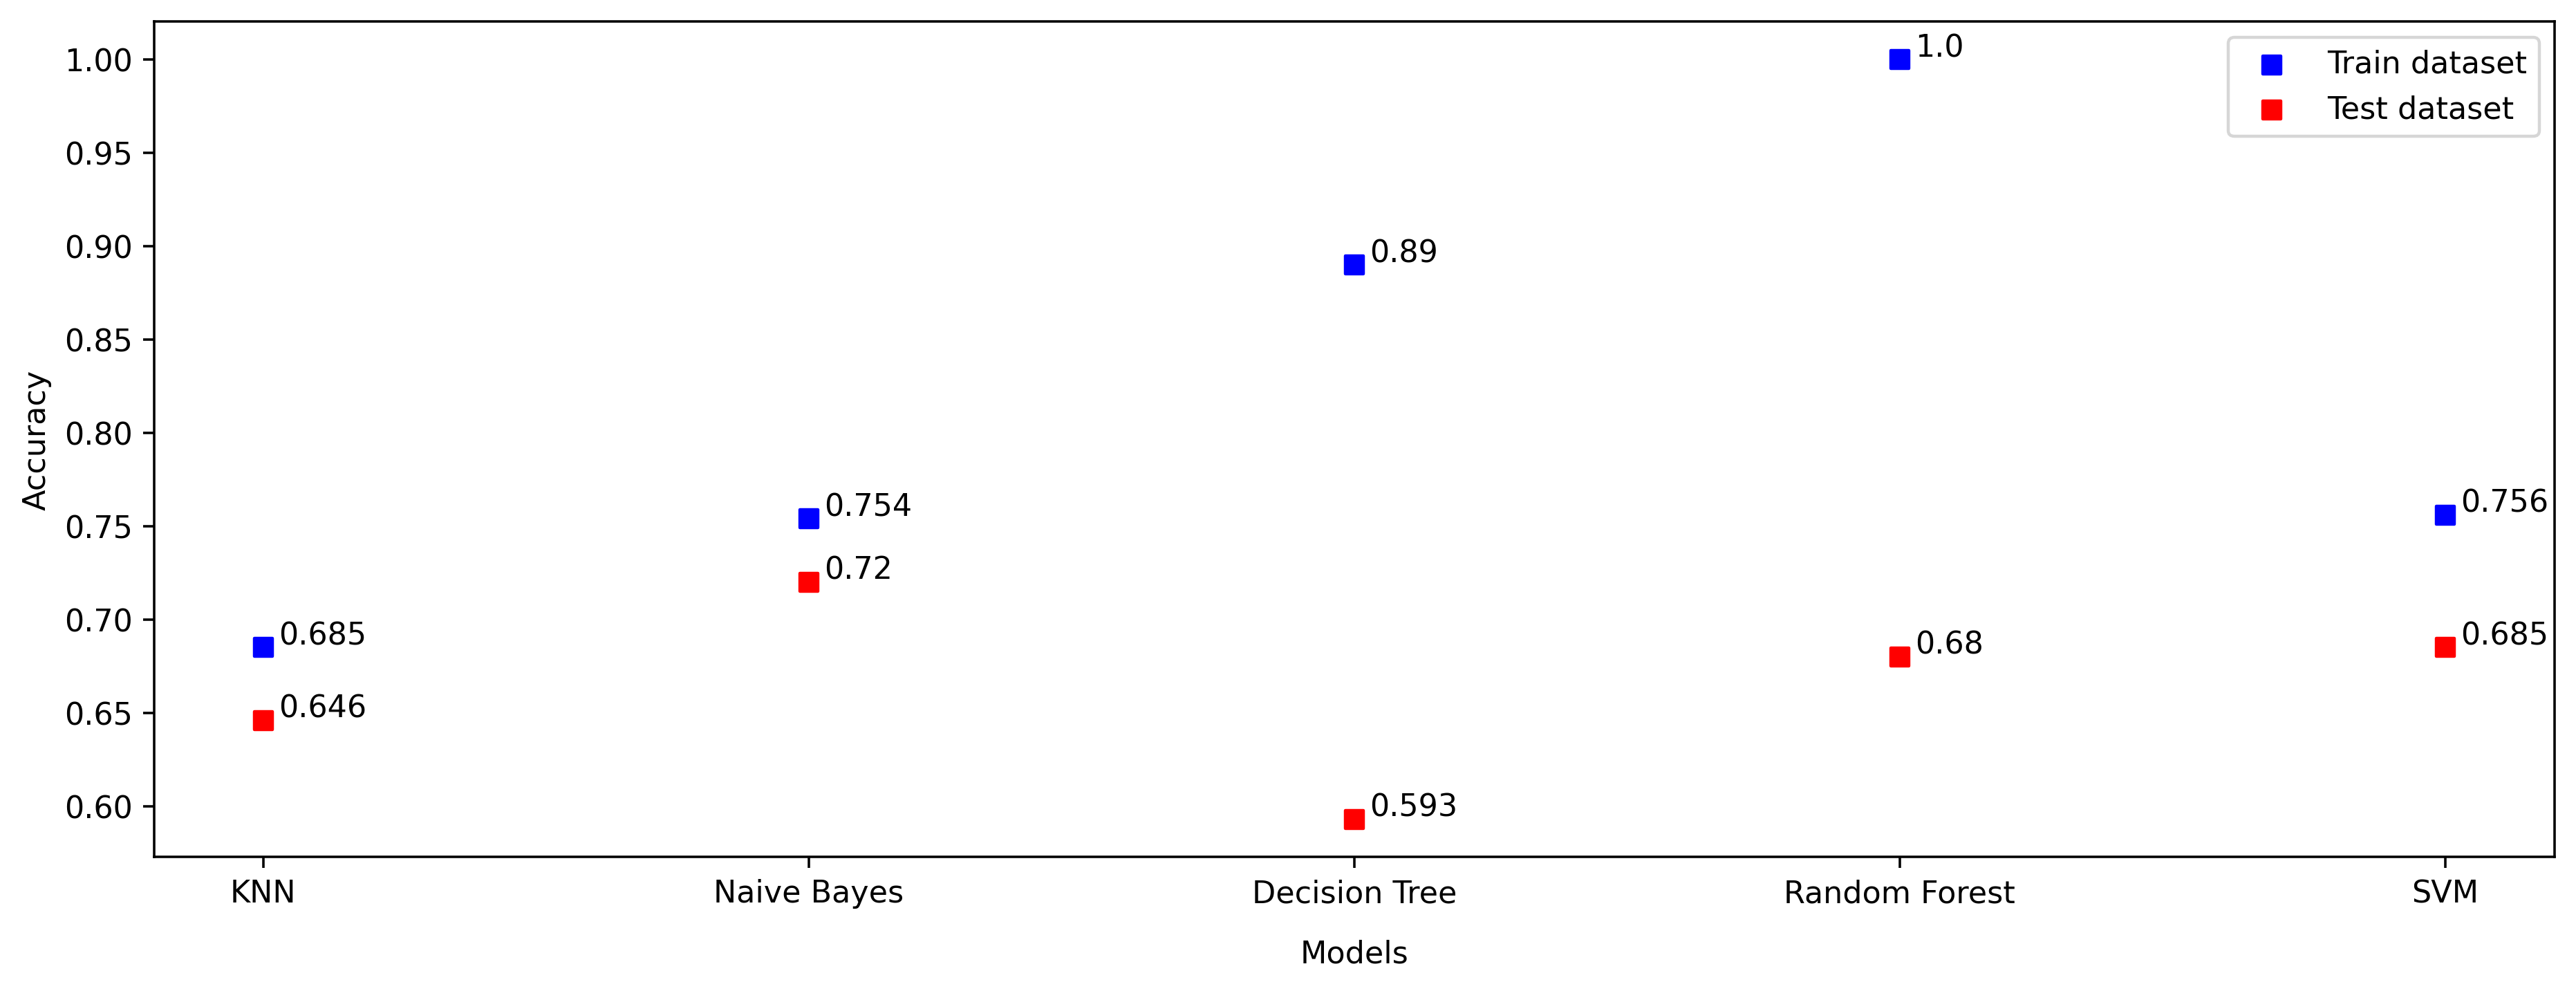

In [20]:
models = [model_knn, model_naive_bayes, model_decision_tree, model_random_forest, model_svm]
x_labels = ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'SVM']

train_errors = []
test_errors = []

print("Accuracy Score")

for model, name in zip(models, x_labels):
    y_pred = model.predict(X_train)
    score_train = round(accuracy_score(y_train, y_pred), 3)
    train_errors.append(score_train)

    y_pred = model.predict(X_test)
    score_test = round(accuracy_score(y_test, y_pred), 3)
    test_errors.append(score_test)

    print("--- {}:\ntrain = {}, test = {}\n".format(name, score_train, score_test))

plt.figure(figsize=(14, 5), dpi= 320)
plt.xlabel("Models", labelpad=10)
plt.ylabel("Accuracy")

plt.scatter(x_labels, train_errors, c='b', marker="s", label='Train dataset')
plt.scatter(x_labels, test_errors, c='r', marker="s", label='Test dataset')

for i, txt in enumerate(train_errors):
    plt.annotate(txt, (x_labels[i], train_errors[i]), xytext=(5,1) ,textcoords='offset points')
    
for i, txt in enumerate(test_errors):
    plt.annotate(txt, (x_labels[i], test_errors[i]), xytext=(5,1) ,textcoords='offset points')

plt.legend()

F1 Score
--- KNN:
train = 0.715, test = 0.691

--- Naive Bayes:
train = 0.777, test = 0.757

--- Decision Tree:
train = 0.898, test = 0.632

--- Random Forest:
train = 1.0, test = 0.731

--- SVM:
train = 0.784, test = 0.73



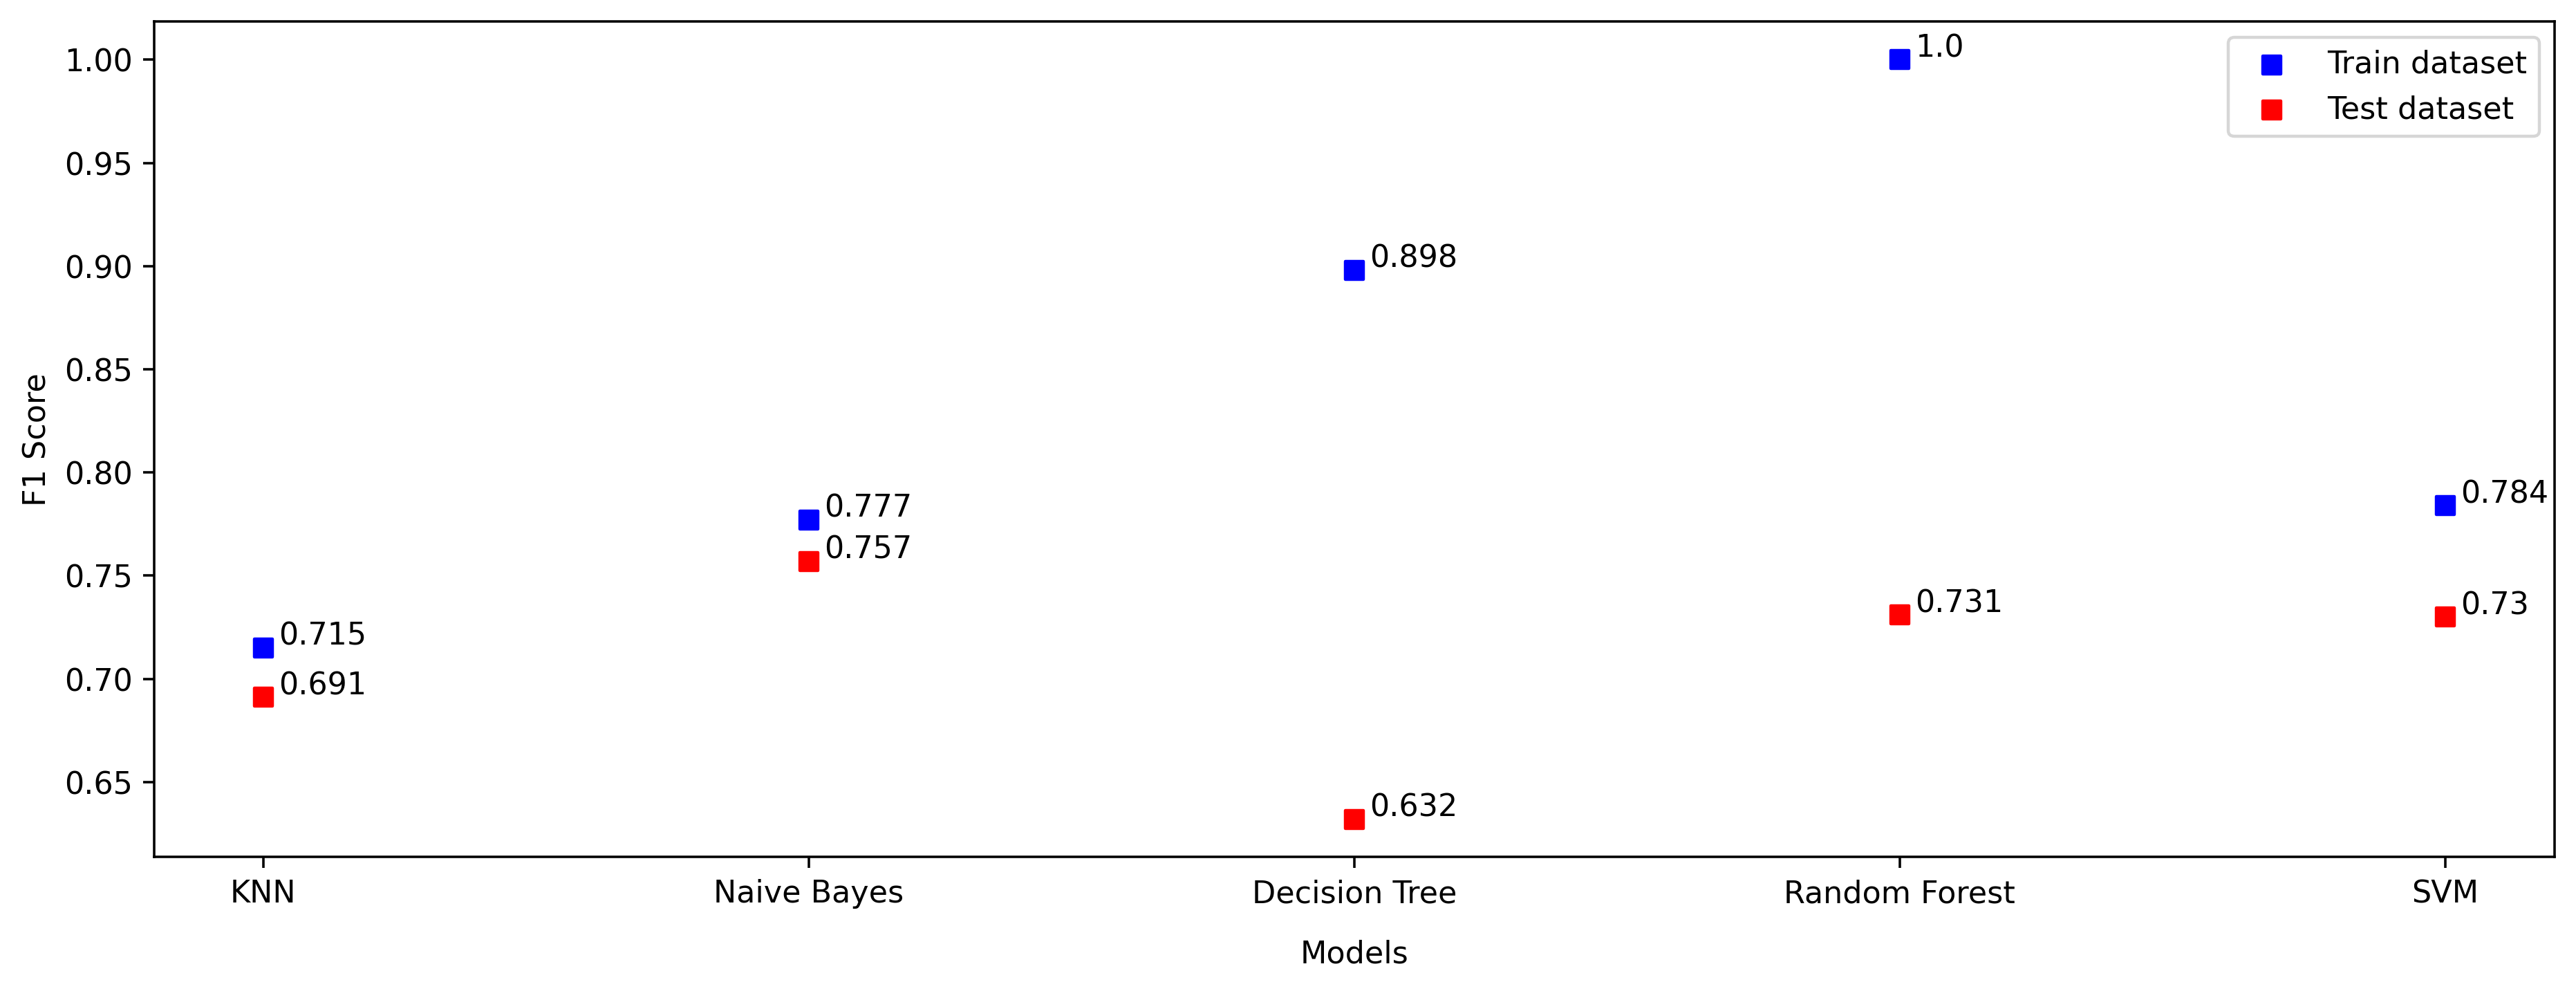

In [21]:
models = [model_knn, model_naive_bayes, model_decision_tree, model_random_forest, model_svm]
x_labels = ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'SVM']

train_errors = []
test_errors = []

print("F1 Score")

for model, name in zip(models, x_labels):
    y_pred = model.predict(X_train)
    score_train = round(f1_score(y_train, y_pred), 3)
    train_errors.append(score_train)

    y_pred = model.predict(X_test)
    score_test = round(f1_score(y_test, y_pred), 3)
    test_errors.append(score_test)

    print("--- {}:\ntrain = {}, test = {}\n".format(name, score_train, score_test))

plt.figure(figsize=(14, 5), dpi= 320)
plt.xlabel("Models", labelpad=10)
plt.ylabel("F1 Score")

plt.scatter(x_labels, train_errors, c='b', marker="s", label='Train dataset')
plt.scatter(x_labels, test_errors, c='r', marker="s", label='Test dataset')

for i, txt in enumerate(train_errors):
    plt.annotate(txt, (x_labels[i], train_errors[i]), xytext=(5,1) ,textcoords='offset points')
    
for i, txt in enumerate(test_errors):
    plt.annotate(txt, (x_labels[i], test_errors[i]), xytext=(5,1) ,textcoords='offset points')

plt.legend()